In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

### DATA PREPARATION

In [2]:
df = pd.read_csv('course_lead_scoring.csv')
df.head(10)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
5,events,manufacturing,1,59904.0,NaN,africa,6,0.83,1
6,social_media,technology,0,51283.0,NaN,middle_east,2,0.57,0
7,social_media,NaN,5,62975.0,student,europe,4,0.62,1
8,referral,healthcare,4,38648.0,unemployed,south_america,2,0.86,1
9,paid_ads,other,3,59866.0,student,australia,3,0.43,1


In [3]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [4]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [5]:
categorical_features = ['lead_source', 'industry', 'employment_status', 'location']	
numerical_features = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

for categorical_feature in categorical_features:
    df[categorical_feature] = df[categorical_feature].str.lower().str.replace(' ', '_')
    df[categorical_feature] = df[categorical_feature].fillna('NA')

for numerical_feature in numerical_features:
    df[numerical_feature] = df[numerical_feature].fillna(0.0)

In [6]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train_full_df, test_df = train_test_split(df, test_size = 0.2, random_state = 1)
train_df, validation_df = train_test_split(train_full_df, test_size = 0.25, random_state = 1)

len(train_df), len(validation_df), len(test_df)

(876, 293, 293)

In [9]:
y_train = train_df.converted.values
y_validation = validation_df.converted.values
y_test = test_df.converted.values

### QUESTION 1

In [10]:
from sklearn.metrics import roc_auc_score

In [11]:
for numerical_feature in numerical_features:
    auc_score = roc_auc_score(train_df.converted, train_df[numerical_feature])

    if auc_score < 0.5:
        print(f"Numerical Feature: {numerical_feature} => {roc_auc_score(train_df.converted, -train_df[numerical_feature])}")
    else:
        print(f"Numerical Feature: {numerical_feature} => {auc_score}")

Numerical Feature: number_of_courses_viewed => 0.7635680590007088
Numerical Feature: annual_income => 0.5519578313253012
Numerical Feature: interaction_count => 0.738270176293409
Numerical Feature: lead_score => 0.6144993577250176


### QUESTION 2

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

In [13]:
# creating a one-hot encoding matrix
dicts = train_df[categorical_features + numerical_features].to_dict(orient = 'records')

div = DictVectorizer(sparse = False)
X_train = div.fit_transform(dicts)

model = LogisticRegression(solver = 'liblinear', C = 1.0, max_iter = 1000)
model.fit(X_train, y_train)

validation_dict = validation_df[categorical_features + numerical_features].to_dict(orient = 'records')
X_validation = div.transform(validation_dict)
y_predictions = model.predict_proba(X_validation)[:, 1]

round(roc_auc_score(y_validation, y_predictions), 3)

0.817

### QUESTION 3

In [14]:
del train_df['converted']
del validation_df['converted']
del test_df['converted']

/tmp/ipykernel_4960/788184254.py:17: RuntimeWarning: invalid value encountered in scalar divide
  recall = true_positive / (false_negative + true_positive)


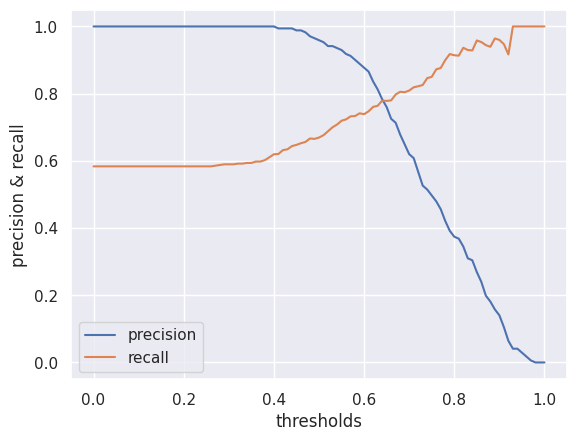

In [15]:
thresholds = np.linspace(0, 1, 101)
scores = []

for threshold in thresholds:
    actual_positive = (y_validation == 1)
    actual_negative = (y_validation == 0)

    predict_positive = (y_predictions >= threshold)
    predict_negative = (y_predictions < threshold)

    true_positive = (actual_positive & predict_positive).sum()
    true_negative = (actual_negative & predict_negative).sum()
    false_positive = (actual_positive & predict_negative).sum()
    false_negative = (actual_negative & predict_positive).sum()

    precision = true_positive / (false_positive + true_positive)
    recall = true_positive / (false_negative + true_positive)
    recall = np.nan_to_num(recall, nan = 1.0)

    scores.append((threshold, precision, recall))

columns = ['threshold', 'precision', 'recall']
thresholds_df = pd.DataFrame(scores, columns = columns)

plt.plot(thresholds_df.threshold, thresholds_df.precision, label = 'precision')
plt.plot(thresholds_df.threshold, thresholds_df.recall, label = 'recall')
plt.xlabel('thresholds')
plt.ylabel('precision & recall')
plt.legend()
plt.show()

In [16]:
thresholds_df.iloc[np.argmin(np.abs(thresholds_df.precision - thresholds_df.recall))]

threshold    0.640000
precision    0.783626
recall       0.779070
Name: 64, dtype: float64

### QUESTION 4

In [17]:
thresholds_df["f1_score"] = 2 * (thresholds_df.precision * thresholds_df.recall) / (thresholds_df.precision + thresholds_df.recall)
thresholds_df[thresholds_df.f1_score == thresholds_df.f1_score.max()]

,threshold,precision,recall,f1_score
57,0.57,0.912281,0.732394,0.8125


### QUESTION 5

In [18]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

In [19]:
k_dv = DictVectorizer(sparse = False)
k_model = LogisticRegression(solver = 'liblinear', C = 1.0, max_iter = 1000)

def train(train_df, y_train):
    k_dicts = train_df.to_dict(orient = 'records')
    K_train = k_dv.fit_transform(k_dicts)
    
    k_model.fit(K_train, y_train)

    return k_dv, k_model

def predict(train_df, k_dv, k_model):
    k_dicts = train_df.to_dict(orient = 'records')
    X = k_dv.transform(k_dicts)
    y_prediction = k_model.predict_proba(X)[:, 1]

    return y_prediction

In [21]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)
train_idx, validation_idx = next(kfold.split(train_full_df))

kuc_scores = []

for train_idx, validation_idx in kfold.split(train_full_df):
    k_train_df = train_full_df.iloc[train_idx]
    k_validation_df = train_full_df.iloc[validation_idx]

    k_train = k_train_df.converted.values
    k_validation = k_validation_df.converted.values
    
    k_dv, k_model = train(k_train_df[categorical_features + numerical_features], k_train)
    k_prediction = predict(k_validation_df[categorical_features + numerical_features], k_dv, k_model)

    auc_score = roc_auc_score(k_validation, k_prediction)
    kuc_scores.append(auc_score)

print("auc score = %0.3f ± %0.3f" % (np.mean(kuc_scores), np.std(kuc_scores)))

auc score = 0.822 ± 0.036


### QUESTION 6

In [22]:
kc_dv = DictVectorizer(sparse = False)


def train(train_df, yc_train, C):
    kc_dicts = train_df.to_dict(orient = 'records')
    KC_train = kc_dv.fit_transform(kc_dicts)

    kc_model = LogisticRegression(solver = 'liblinear', C = C, max_iter = 1000)
    kc_model.fit(KC_train, yc_train)

    return kc_dv, kc_model

def predict(train_df, kc_dv, kc_model):
    kc_dicts = train_df.to_dict(orient = 'records')
    X_c = kc_dv.transform(kc_dicts)
    yc_prediction = kc_model.predict_proba(X_c)[:, 1]

    return yc_prediction

In [23]:
kcfold = KFold(n_splits = 5, shuffle = True, random_state = 1)
c_train_idx, c_validation_idx = next(kcfold.split(train_full_df))

In [24]:
c_parameters = [0.000001, 0.001, 1]
kc_scores = []

kc_dv = DictVectorizer(sparse = False)

for c_parameter in c_parameters:
    for c_train_idx, c_validation_idx in kcfold.split(train_full_df):
        kc_train_df = train_full_df.iloc[c_train_idx]
        kc_validation_df = train_full_df.iloc[c_validation_idx]

        kc_train = kc_train_df.converted.values
        kc_validation = kc_validation_df.converted.values
    
        kc_dv, kc_model = train(kc_train_df[categorical_features + numerical_features], kc_train, c_parameter)
        kc_prediction = predict(kc_validation_df[categorical_features + numerical_features], kc_dv, kc_model)

        auc_score = roc_auc_score(kc_validation, kc_prediction)
        kc_scores.append(auc_score)
    print(f"auc score for {c_parameter} => %0.3f ± %0.3f" % (np.mean(kc_scores), np.std(kc_scores)))

auc score for 1e-06 => 0.560 ± 0.024
auc score for 0.001 => 0.714 ± 0.156
auc score for 1 => 0.750 ± 0.139


### Save the Model

In [25]:
import pickle

In [27]:
output_file = f'model_C={c_parameter}.bin'

with open(output_file, 'wb') as f_out:
    pickle.dump((kc_dv, kc_model), f_out)

### Load the Model

In [29]:
with open(output_file, 'rb') as f_in:
   dv, model = pickle.load(f_in)

In [30]:
dv, model

(DictVectorizer(sparse=False),
 LogisticRegression(C=1, max_iter=1000, solver='liblinear'))